In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt

import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from sklearn.cluster import KMeans
from scipy.ndimage.morphology import binary_fill_holes
import cv2 
import seaborn as sns              # For pairplots
import matplotlib.cm as cm         # Color map
%matplotlib inline 
import random
import warnings
from itertools import chain

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
from keras import backend as K

import tensorflow as tf


# Set some parameters
IMG_WIDTH = 256
IMG_HEIGHT = 256
IMG_CHANNELS = 1
TRAIN_PATH = 'C:/input/stage1_train/'
TEST_PATH = 'C:/input/stage1_test/'
# Global constants.
TRAIN_DIR = 'C:/input/stage1_train'
TEST_DIR = 'C:/input/stage1_test'
IMG_DIR_NAME = 'augs'   # Folder name including the image
MASK_DIR_NAME = 'augs_masks'
IMG_TESTDIR_NAME = 'images'# Folder name including the masks
warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed

Using TensorFlow backend.


In [2]:
# Collection of methods for data operations. Implemented are functions to read  
# images/masks from files and to read basic properties of the train/test data sets.

def read_image(filepath, color_mode=cv2.IMREAD_COLOR, target_size=None,space='bgr'):
    """Read an image from a file and resize it."""
    img = cv2.imread(filepath, color_mode)
    if target_size: 
        img = cv2.resize(img, target_size, interpolation = cv2.INTER_AREA)
    if space == 'hsv':
        img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return img

def read_train_data_properties(train_dir, img_dir_name, mask_dir_name):
    """Read basic properties of training images and masks"""
    tmp = []
    for i,img_name_id in enumerate(aug_train_ids):

        dir_name = img_name_id.rsplit('_',1)[0]
        img_dir = os.path.join(train_dir, dir_name, img_dir_name)
        mask_dir = os.path.join(train_dir, dir_name, mask_dir_name) 
        img_name = img_name_id+'.png'
        img_path = os.path.join(img_dir, img_name)
        mask_path = os.path.join(mask_dir,img_name)
        img_shape = read_image(img_path).shape
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2],
                    img_path, mask_dir,mask_path])

    train_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                            'img_ratio', 'num_channels', 
                                            'image_path', 'mask_dir','mask_path'])
    return train_df


def read_test_data_properties(test_dir, img_dir_name):
    """Read basic properties of test images."""
    tmp = []
    for i,dir_name in enumerate(next(os.walk(test_dir))[1]):

        img_dir = os.path.join(test_dir, dir_name, img_dir_name)
        img_name = next(os.walk(img_dir))[2][0]
        img_name_id = os.path.splitext(img_name)[0]
        img_path = os.path.join(img_dir, img_name)
        img_shape = read_image(img_path).shape
        tmp.append(['{}'.format(img_name_id), img_shape[0], img_shape[1],
                    img_shape[0]/img_shape[1], img_shape[2], img_path])

    test_df = pd.DataFrame(tmp, columns = ['img_id', 'img_height', 'img_width',
                                           'img_ratio', 'num_channels', 'image_path'])
    return test_df

def load_raw_data(image_size=(256, 256), space = 'bgr',load_mask=True):
    """Load raw data."""
    # Python lists to store the training images/masks and test images.
    x_train, y_train, x_test = [],[],[]

    # Read and resize train images/masks. 
    print('Loading and resizing train images and masks ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(train_df['image_path']), total=len(train_df)):
        img = read_image(train_df['image_path'].loc[i], target_size=image_size,space = space)
        if load_mask:
            mask = read_image(train_df['mask_path'].loc[i],
                              color_mode=cv2.IMREAD_GRAYSCALE,
                              target_size=image_size)
            #mask = read_mask(train_df['mask_dir'].loc[i], target_size=image_size)
            y_train.append(mask)
        x_train.append(img)
        
    # Read and resize test images. 
    print('Loading and resizing test images ...')
    sys.stdout.flush()
    for i, filename in tqdm.tqdm(enumerate(test_df['image_path']), total=len(test_df)):
        img = read_image(test_df['image_path'].loc[i], target_size=image_size,space=space)
        x_test.append(img)

    # Transform lists into 4-dim numpy arrays.
    x_train = np.array(x_train)
    #if load_mask:
    y_train = np.array(y_train)
    #y_train = np.expand_dims(np.array(y_train), axis=4)
    x_test = np.array(x_test)
    print('Data loaded')
    if load_mask:
        return x_train, y_train, x_test
    else:
        return x_train, x_test

def get_domimant_colors(img, top_colors=1):
    """Return dominant image color"""
    img_l = img.reshape((img.shape[0] * img.shape[1], img.shape[2]))
    clt = KMeans(n_clusters = top_colors)
    clt.fit(img_l)
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)
    (hist, _) = np.histogram(clt.labels_, bins = numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    return clt.cluster_centers_, hist

def cluster_images_by_hsv():
    """Clusterization based on hsv colors. Adds 'hsv_cluster' column to tables"""
    print('Loading data')
    x_train_hsv,x_test_hsv = load_raw_data(image_size=None,space='hsv',load_mask=False)
    x_hsv = np.concatenate([x_train_hsv,x_test_hsv])
    print('Calculating dominant hsv for each image')
    dominant_hsv = []
    for img in tqdm.tqdm(x_hsv):
        res1, res2 = get_domimant_colors(img,top_colors=1)
        dominant_hsv.append(res1.squeeze())
    print('Calculating clusters')
    kmeans = KMeans(n_clusters=3).fit(dominant_hsv)
    train_df['HSV_CLUSTER'] = kmeans.predict(dominant_hsv[:len(x_train_hsv)])
    test_df['HSV_CLUSTER'] = kmeans.predict(dominant_hsv[len(x_train_hsv):])
    print('Images clustered')
    return None

def plot_images(selected_images_df,images_rows=4,images_cols=8,plot_figsize=4):
    """Plot image_rows*image_cols of selected images. Used to visualy check clusterization"""
    f, axarr = plt.subplots(images_rows,images_cols,figsize=(plot_figsize*images_cols,images_rows*plot_figsize))
    for row in range(images_rows):
        for col in range(images_cols):
            if (row*images_cols + col) < selected_images_df.shape[0]:
                image_path = selected_images_df['image_path'].iloc[row*images_cols + col]
            else:
                continue
            img = read_image(image_path)
            height, width, l = img.shape
            ax = axarr[row,col]
            ax.axis('off')
            ax.set_title("%dx%d"%(width, height))
            ax.imshow(img)
            


def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# Custom loss function
def dice_coef(y_true, y_pred):
    smooth = 1.
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    return 0.5 * keras.losses.binary_crossentropy(y_true, y_pred) - dice_coef(y_true, y_pred)

In [3]:
train_ids = next(os.walk(TRAIN_PATH))[1]
test_ids = next(os.walk(TEST_PATH))[1]
aug_train_ids = []
for i,id_ in enumerate(train_ids):
    aug_train_ids.append(id_)
    for i in range(2):
        aug_train_ids.append(id_+'_'+str(i))
        
# Basic properties of images/masks. 
#train_df = read_train_data_properties(TRAIN_DIR, IMG_DIR_NAME, MASK_DIR_NAME)
#test_df = read_test_data_properties(TEST_DIR, IMG_TESTDIR_NAME)
#cluster_images_by_hsv()
#train_df.to_csv('./train_df.csv',index=False)
#test_df.to_csv('./test_df.csv',index=False)

# We don't need to compute everything (especially clusters) every time. simly load them
train_df = pd.read_csv('./train_df.csv')
test_df = pd.read_csv('./test_df.csv')

# we need to change filepath from my filesystem to kaggle filesystem
# train_change_filepath = lambda x: '../input/data-science-bowl-2018/stage1_train/{0}/images/{0}.png'.format(x.split('/')[-1][:-4])
# test_change_filepath = lambda x: '../input/data-science-bowl-2018/stage1_test/{0}/images/{0}.png'.format(x.split('/')[-1][:-4])
# train_df.image_path = train_df.image_path.map(train_change_filepath)
# train_df.drop(['mask_dir','mask_path'],inplace=True,axis = 1)
# test_df.image_path = test_df.image_path.map(test_change_filepath)

In [4]:
for idx in range(3):
    print("Images in cluster {}: {}".format(idx,train_df[train_df['HSV_CLUSTER'] == idx].shape[0]))

Images in cluster 0: 544
Images in cluster 1: 108
Images in cluster 2: 18


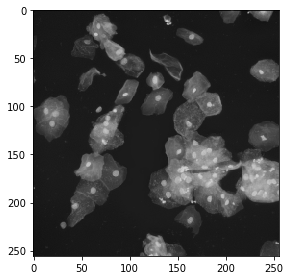

In [10]:
img = imread(train_df[train_df['HSV_CLUSTER']==2]['image_path'].iloc[17])[:,:,:IMG_CHANNELS]
img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
img = cv2.bitwise_not(img)
img = np.expand_dims(img, axis=-1)
imshow(np.squeeze(img),cmap='gray')
plt.show()

In [18]:
from tqdm import tqdm
# Get and resize train images and masks
X_train = np.zeros((len(aug_train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(aug_train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(aug_train_ids), total=len(aug_train_ids)):
    idp = id_.rsplit('_',1)[0]
    path = TRAIN_PATH + idp
    img = imread(path + '/augs/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    img = cv2.resize(img, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    if (train_df['HSV_CLUSTER'].iloc[n]==0): 
        img = cv2.bitwise_not(img)
    if (train_df['HSV_CLUSTER'].iloc[n]==2): 
        img = cv2.bitwise_not(img)
    img = np.expand_dims(img, axis=-1)
    X_train[n] = img
    mask = imread(path + '/augs_masks/' + id_ + '.png',cmap='gray')[:,:,:IMG_CHANNELS]
    mask = cv2.resize(mask, (IMG_HEIGHT, IMG_WIDTH), interpolation = cv2.INTER_AREA)
    ret,mask = cv2.threshold(mask,127,255,cv2.THRESH_BINARY)
    mask = np.expand_dims(mask,axis=-1)
    Y_train[n] = mask        

# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH + id_
    img = imread(path + '/images/' + id_ + '.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
    X_test[n] = img

print('Done!')

Getting and resizing train images and masks ... 


100%|██████████████████████████████████████████████████████████████████████████████| 2010/2010 [00:36<00:00, 55.48it/s]


Getting and resizing test images ... 


100%|██████████████████████████████████████████████████████████████████████████████████| 65/65 [00:01<00:00, 46.22it/s]


Done!


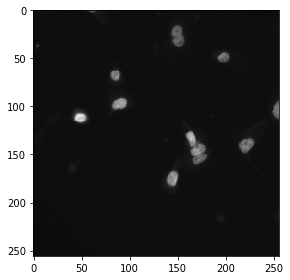

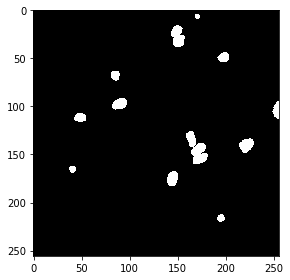

In [19]:
# Check if training data looks all right
ix = random.randint(0, len(aug_train_ids))
imshow(np.squeeze(X_train[ix]))
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()

In [22]:
# Build U-Net model
inputs = Input((256, 256, 1))
inp_norm = BatchNormalization(axis=1)(inputs)
s = Lambda(lambda x: x / 255) (inp_norm)

c0 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
c0 = Dropout(0.1) (c0)
c0 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c0)
c0 = BatchNormalization(axis=1)(c0)
p0 = MaxPooling2D((2, 2)) (c0)

c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p0)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
c1 = BatchNormalization(axis=1)(c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
c2 = BatchNormalization(axis=1)(c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
c3 = BatchNormalization(axis=1)(c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
c4 = BatchNormalization(axis=1)(c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)
c5 = BatchNormalization(axis=1)(c5)

u6 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)
c6 = BatchNormalization(axis=1)(c6)

u7 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)
c7 = BatchNormalization(axis=1)(c7)

u8 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)
c8 = BatchNormalization(axis=1)(c8)

u9 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)
c9 = BatchNormalization(axis=1)(c9)

u10 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c9)
u10 = concatenate([u10, c0], axis=3)
c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u10)
c10 = Dropout(0.1) (c10)
c10 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c10)
c10 = BatchNormalization(axis=1)(c10)
outputs = Conv2D(1, (1, 1), activation='sigmoid') (c10)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss = bce_dice_loss, metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 1)  1024        input_4[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 256, 256, 1)  0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_70 (Conv2D)              (None, 256, 256, 16) 160         lambda_4[0][0]                   
__________________________________________________________________________________________________
dropout_34

In [23]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('pre+augumention.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, shuffle=True, batch_size=16, epochs=50, 
                    callbacks=[earlystopper, checkpointer])

Train on 1809 samples, validate on 201 samples
Epoch 1/50
1809/1809 [==============================] - 6434s 4s/step - loss: -0.5273 - dice_coef: 0.6382 - val_loss: 1.0480 - val_dice_coef: 1.2754e-05
Epoch 2/50
1809/1809 [==============================] - 5907s 3s/step - loss: -0.7141 - dice_coef: 0.7876 - val_loss: 0.7916 - val_dice_coef: 3.3122e-05
Epoch 3/50


1809/1809 [==============================] - 6737s 4s/step - loss: -0.7715 - dice_coef: 0.8347 - val_loss: 0.7502 - val_dice_coef: 1.3132e-04
Epoch 4/50
1809/1809 [==============================] - 7436s 4s/step - loss: -0.7875 - dice_coef: 0.8489 - val_loss: 0.5895 - val_dice_coef: 0.0205
Epoch 5/50


1809/1809 [==============================] - 6184s 3s/step - loss: -0.7878 - dice_coef: 0.8486 - val_loss: -0.5625 - val_dice_coef: 0.6835
Epoch 6/50
1809/1809 [==============================] - 6458s 4s/step - loss: -0.7992 - dice_coef: 0.8569 - val_loss: -0.5998 - val_dice_coef: 0.7280
Epoch 7/50


1809/1809 [==============================] - 5865s 3s/step - loss: -0.8115 - dice_coef: 0.8656 - val_loss: -0.5505 - val_dice_coef: 0.6812
Epoch 8/50
1809/1809 [==============================] - 5858s 3s/step - loss: -0.8136 - dice_coef: 0.8671 - val_loss: -0.7963 - val_dice_coef: 0.8603
Epoch 9/50


1809/1809 [==============================] - 5843s 3s/step - loss: -0.8221 - dice_coef: 0.8733 - val_loss: -0.6945 - val_dice_coef: 0.7887
Epoch 10/50
1809/1809 [==============================] - 5965s 3s/step - loss: -0.8255 - dice_coef: 0.8757 - val_loss: -0.7561 - val_dice_coef: 0.8312
Epoch 11/50


1809/1809 [==============================] - 5912s 3s/step - loss: -0.8222 - dice_coef: 0.8730 - val_loss: -0.8164 - val_dice_coef: 0.8683
Epoch 12/50
1809/1809 [==============================] - 5872s 3s/step - loss: -0.8267 - dice_coef: 0.8768 - val_loss: -0.7495 - val_dice_coef: 0.8288
Epoch 13/50


1809/1809 [==============================] - 5876s 3s/step - loss: -0.8216 - dice_coef: 0.8728 - val_loss: -0.7540 - val_dice_coef: 0.8323
Epoch 14/50
1809/1809 [==============================] - 6273s 3s/step - loss: -0.8266 - dice_coef: 0.8764 - val_loss: -0.5885 - val_dice_coef: 0.7100
Epoch 15/50


1809/1809 [==============================] - 5887s 3s/step - loss: -0.8285 - dice_coef: 0.8778 - val_loss: -0.7975 - val_dice_coef: 0.8599
Epoch 16/50
1809/1809 [==============================] - 6015s 3s/step - loss: -0.8389 - dice_coef: 0.8854 - val_loss: -0.8006 - val_dice_coef: 0.8603
Epoch 00016: early stopping
